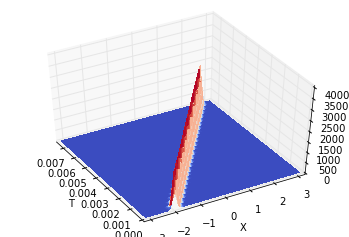

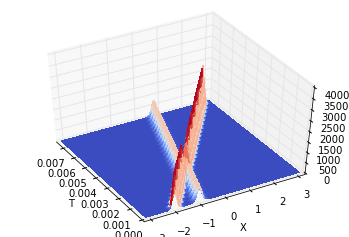

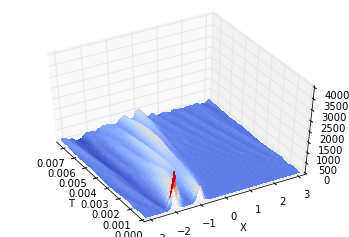

In [2]:
from __future__ import division
from math import sqrt, pi
import numpy as np
from scipy.fftpack import fft, ifft	
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

def initialize_all(y0, t0, t1, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size),dtype=complex).squeeze()
    else:
        Y = np.empty(n,dtype=complex)
    Y[0] = y0
    T = np.linspace(t0, t1, n)
    h = float(t1 - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t1, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    'y0' is assumed to be either a constant or a one-dimensional numpy array.
    't0' and 't1' are assumed to be constants.
    'f' is assumed to accept two arguments.
    The first is a constant giving the current value of t.
    The second is a one-dimensional numpy array of the same size as y.
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y, T, h = initialize_all(y0, t0, t1, n)
    for i in xrange(1, n):
        K1 = f(T[i-1], Y[i-1])
        tplus = (T[i] + T[i-1]) * .5
        K2 = f(tplus, Y[i-1] + .5 * h * K1)
        K3 = f(tplus, Y[i-1] + .5 * h * K2)
        K4 = f(T[i], Y[i-1] + h * K3)
        Y[i] = Y[i-1] + (h / 6.) * (K1 + 2 * K2 + 2 * K3 + K4)
    return T, Y

def solve_da_thing(u,tmax,c,N=256,Zsub = False):
    # Array of wave numbers. This array is reordered in Python to
    # accomodate the ordering inside the fft function in scipy.
    zero = np.array([0])
    k = np.concatenate((np.arange(0,N/2),zero,np.arange(-N/2+1,0,1))).reshape(N,)

    # Defines the left hand side of the ODE y' = G(t,y)
    # defined above.
    ik3 = 1j*k**3.
    def G_unscaled(t,y):
        if Zsub:
            out = -.5*1j*k*np.exp(-1.*ik3*t)*fft(ifft(y,axis=0)**2.,axis=0) 
        else:
            out = -.5*1j*k*fft(ifft(y,axis=0)**2.,axis=0) + ik3*y
        return out

    x = (2.*np.pi/N)*np.arange(-N/2,N/2).reshape(N,1) # Space discretization
    s, shift = 25.**2., 2. # Initial data is a soliton
    #y0 = (3.*s*np.cosh(.5*(sqrt(s)*(x+shift)))**(-2.)).reshape(N,)
    y0 = u(x)
    
    # Solves the ODE.
    max_t = tmax
    dt = c*N**(-2.)# constant*N**(-2.)
    max_tsteps = int(round(max_t/dt))
    y0 = fft(y0,axis=0)
    y0 = y0.reshape(len(y0),)
    T,Y = RK4(G_unscaled, y0, t0=0, t1=max_t, n=max_tsteps)
    #if Zsub:
    #    Y = np.exp(1.*ik3*T)*Y

    # Using the variable stride, we step through the data,
    # applying the inverse fourier transform to obtain u.
    # These values will be plotted.
    stride = int(np.floor((max_t/25.)/dt))
    uvalues, tvalues = np.real(ifft(y0,axis=0)).reshape(N,1), np.array(0.).reshape(1,1)

    for n in range(1,max_tsteps+1):
        if np.mod(n,stride) == 0:
            t = n*dt
            if Zsub:
                Y[n] = np.exp(1.*ik3*t)*Y[n]
            u = np.real( ifft(Y[n], axis=0) ).reshape(N,1)
            uvalues = np.concatenate((uvalues,np.nan_to_num(u)),axis=1)
            tvalues = np.concatenate((tvalues,np.array(t).reshape(1,1)),axis=1)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(elev=45., azim=150)
    tv, xv = np.meshgrid(tvalues,x,indexing='ij')
    surf = ax.plot_surface(tv,xv, uvalues.T, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    tvalues = tvalues[0]; ax.set_xlim(tvalues[0], tvalues[-1])
    ax.set_ylim(-pi, pi); ax.invert_yaxis()
    ax.set_zlim(0., 4000.)
    ax.set_xlabel('T'); ax.set_ylabel('X'); ax.set_zlabel('Z')
    plt.show()

def prob1():
    # Plot and show the numerical solution
    def u(x):
        s = 25.**2
        a = 2.
        return 3.0*s*1/np.cosh(np.sqrt(s)/2.*(x+a))**2
    solve_da_thing(u,0.0075,0.01)


def prob2():
    # Plot and show the numerical solution
    def u(x):
        s1 = 25.**2
        a1 = 2.
        s2 = 16.**2
        a2 = 1.
        return 3.0*s1*1/np.cosh(np.sqrt(s1)/2.*(x+a1))**2 + 3.0*s2*1/np.cosh(np.sqrt(s2)/2.*(x+a2))**2
    solve_da_thing(u,0.0075,0.01)


def prob3():
    def u(x):
        s1 = 25.**2
        a1 = 2.
        s2 = 16.**2
        a2 = 1.
        return 3.0*s1*1/np.cosh(np.sqrt(s1)/2.*(x+a1))**2 + 3.0*s2*1/np.cosh(np.sqrt(s2)/2.*(x+a2))**2
    solve_da_thing(u,0.0075,0.01,Zsub=True)
    
    #return (solution at the final time)
    
prob1()
prob2()
prob3()